# **Tugas 2 MA4072 - Pembelajaran Mendalam**

oleh: \\
Michella Chandra - 10118011 \\
Thirafi Najwan Kurniatama - 13520157

Akan dibuat 4 buah model Deep Learning dengan berbagai kombinasi fungsi aktivasi sebagai berikut: 
1.   hidden layers memakai fungsi aktivasi **Sigmoid**, output layer memakai fungsi aktivasi **Softmax** dengan fungsi kerugian (*loss function*) berupa **Cross-Entropy (log-loss)**,
2.   hidden layers memakai fungsi aktivasi **Tanh**, output layer memakai fungsi aktivasi** Softmax** dengan fungsi kerugian (*loss function*) berupa** Cross-Entropy (log-loss)**,
3.   hidden layers memakai fungsi aktivasi **Sigmoid**, output layer memakai fungsi aktivasi **Sigmoid** dengan fungsi biaya (*cost function*) berupa **Mean-Squared Errors (MSE)**, dan
4.   hidden layers memakai fungsi aktivasi **Tanh**, output layer memakai fungsi aktivasi **Sigmoid** dengan fungsi biaya (*cost function*) berupa **Mean-Squared Errors (MSE)**.

Keempat model ini akan diuji menggunakan dua data Eksperimen. Eksperimen pertama berupa  masalah klasikasi angka,  dengan  data training sebanyak 1.797 observasi dan 64 features(variabel). Eksperimen kedua yaitu klasifikasi jenis pakaian, dengan data training sebanyak 60.000 observasi dan 784 features(variables).

## Import Package

In [13]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss, mean_squared_error
from mnist import MNIST
import pickle

## Import Data

Sebagai catatan khusus, nama 'test-images-idx3-ubyte' diganti menjadi 't10k-images-idx3-ubyte' dan 'test-labels-idx1-ubyte' diganti menjadi 't10k-labels-idx1-ubyte'.

Jika ingin load data pakaian, silahkan comment cell ini dan uncomment cell di bawahnya

In [14]:
dat = pickle.load(open('digit/digits.dat', "rb"))
images_tr = dat.data
labels_tr_raw = dat.target
images_tr = np.array(images_tr)
labels_tr_raw = np.array(labels_tr_raw) 
labels_tr = np.zeros((labels_tr_raw.shape[0], np.amax(labels_tr_raw)+1), dtype=int)
for i in range(labels_tr_raw.shape[0]):
    labels_tr[i, labels_tr_raw[i]] = 1

In [15]:
# dat = MNIST('pakaian')
# images_tr, labels_tr_raw = dat.load_training()
# images_ts, labels_ts_raw = dat.load_testing()
# images_tr = np.array(images_tr)
# labels_tr_raw = np.array(labels_tr_raw) 
# images_ts = np.array(images_ts)
# labels_ts_raw = np.array(labels_ts_raw)
# labels_ts = np.zeros((labels_ts_raw.shape[0], np.amax(labels_ts_raw)+1), dtype=int)
# for i in range(labels_ts_raw.shape[0]):
#     labels_ts[i, labels_ts_raw[i]] = 1
# labels_tr = np.zeros((labels_tr_raw.shape[0], np.amax(labels_tr_raw)+1), dtype=int)
# for i in range(labels_tr_raw.shape[0]):
#     labels_tr[i, labels_tr_raw[i]] = 1

## Feature Normalization / Standardization

Berikut adalah kode yang perlu dijalankan ketika feature perlu dinormalisasi/distandarisasi. Apabila ingin dijalankan, silahkan uncomment fungsi.

In [16]:
# NORMALIZATION
# images_tr = (images_tr - np.mean(images_tr, axis=1, keepdims=True))/np.std(images_tr, axis=1, keepdims=True)

# STANDARDIZATION
# images_tr = (images_tr - np.amin(images_tr, axis=1, keepdims=True))/(np.amax(images_tr, axis=1, keepdims=True) - np.amin(images_tr, axis=1, keepdims=True))

In [17]:
print(images_tr.shape)
print(labels_tr.shape)

(1797, 64)
(1797, 10)


## Activation Function

### Fungsi-Fungsi Dasar



In [18]:
def tanh(x):
    return np.tanh(x)
def derivtanh(x):
    return 1.0 - np.tanh(x)**2
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
def derivsoftmax(x):
    return softmax(x) * (1.0 - softmax(x))
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
def dsigmoid(x):
    return sigmoid(x) * (1.0 - sigmoid(x))
def interpretonehot(arr):
    return np.argmax(arr, axis=1)
def err(l1, l2):
    errnum = 0
    for i in range(len(l1)):
        if l1[i] != l2[i]:
            errnum += 1
    return errnum/len(l1)*100

### 1. Fungsi Aktivasi Sigmoid, Softmax untuk Layer Output, dan Loss Function Softmax (Log-Loss)

In [19]:
class DigsNeuralNetworkSigmoidSoftmaxLogloss:
    def __init__(self, dataset, oheoutput, flayer, slayer, learningrate):
        np.random.seed(23638168)
        self.X = dataset
        self.alpha = learningrate
        self.T = dataset.shape[0]
        self.K = dataset.shape[1]
        self.H1 = flayer
        self.H2 = slayer
        self.N0 = oheoutput.shape[1]
        self.output = oheoutput
        # INITIALIZE FIRST PARAM
        limw0 = np.sqrt(6)/np.sqrt(self.K+self.H1)
        self.W0 = np.random.uniform(-limw0, limw0, (self.K, self.H1))
        # INITIALIZE SECOND PARAM
        limw1 = np.sqrt(6)/np.sqrt(self.H1+self.H2)
        self.W1 = np.random.uniform(-limw1, limw1, (self.H1, self.H2))
        # INITIALIZE THIRD PARAM
        limw2 = np.sqrt(6)/np.sqrt(self.H2+self.N0)
        self.W2 = np.random.uniform(-limw2, limw2, (self.H2, self.N0))
        #NADAM PARAM
        self.mW0 = np.zeros((self.K, self.H1))
        self.mW1 = np.zeros((self.H1, self.H2))
        self.mW2 = np.zeros((self.H2, self.N0))
        self.vW0 = np.zeros((self.K, self.H1))
        self.vW1 = np.zeros((self.H1, self.H2))
        self.vW2 = np.zeros((self.H2, self.N0))
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def forward(self, dat=None):
        if dat is None:
            dat = self.X
        self.Z1 = dat@self.W0
        self.A1 = sigmoid(self.Z1)
        self.Z2 = self.A1@self.W1
        self.A2 = sigmoid(self.Z2)
        self.Z3 = self.A2@self.W2
        self.A3 = softmax(self.Z3)
        return self.A3
        
    def backward(self, dat=None, output=None, epoch=0):
        t = dat.shape[0]
        if output is None:
            output = self.output
        if dat is None:
            dat = self.X
        self.delta3 = -1/t * (output - self.A3)
        self.delta2 = self.delta3 @ self.W2.T * dsigmoid(self.Z2)
        self.delta1 = self.delta2 @ self.W1.T * dsigmoid(self.Z1)
        dcdw2 = self.A2.T @ self.delta3
        dcdw1 = self.A1.T @ self.delta2
        dcdw0 = dat.T @ self.delta1
        self.mW0 = self.beta1 * self.mW0 + (1 - self.beta1) * dcdw0
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * dcdw1
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * dcdw2
        self.vW0 = self.beta2 * self.vW0 + (1 - self.beta2) * dcdw0**2
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * dcdw1**2
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * dcdw2**2
        self.mW0hat = self.mW0 / (1 - self.beta1**(epoch+1)) 
        self.mW1hat = self.mW1 / (1 - self.beta1**(epoch+1))
        self.mW2hat = self.mW2 / (1 - self.beta1**(epoch+1))
        self.vW0hat = self.vW0 / (1 - self.beta2**(epoch+1))
        self.vW1hat = self.vW1 / (1 - self.beta2**(epoch+1))
        self.vW2hat = self.vW2 / (1 - self.beta2**(epoch+1))
        self.W2 = self.W2 - (self.alpha * self.mW2hat / (np.sqrt(self.vW2hat) + self.epsilon))
        self.W1 = self.W1 - (self.alpha * self.mW1hat / (np.sqrt(self.vW1hat) + self.epsilon))
        self.W0 = self.W0 - (self.alpha * self.mW0hat / (np.sqrt(self.vW0hat) + self.epsilon))
    
    def train(self, epochs, batch_size=None):
        if batch_size is None:
            batch_size = self.T
        else:
            tmp = list(zip(self.X, self.output))
            np.random.shuffle(tmp)
            self.X, self.output = zip(*tmp)
            self.X = np.array(self.X)
            self.output = np.array(self.output)
        print("Hidden Layer Sigmoid, Output Softmax, Log-Loss")
        for i in range(epochs):
            for j in range(0, self.T, batch_size):
                data = self.X[j:min(j+batch_size, self.T)]
                output = self.output[j:min(j+batch_size, self.T)]
                self.forward(data)
                self.backward(data, output, i)
            if (i+1)%(max(epochs//50,1)) == 0:
                pred = self.forward(self.X)
                print("Epoch: ", i+1, "Cost:", log_loss(self.output, pred), end=" ")
                print("Accuracy:", "%.2f" % (100-err(interpretonehot(self.output), interpretonehot(pred))), "%")

### 2. Fungsi Aktivasi Tanh, Softmax untuk Layer Output, dan Loss Function Softmax (Log-Loss)


In [20]:
class DigsNeuralNetworkTanhSoftmaxLogloss:
    def __init__(self, dataset, oheoutput, flayer, slayer, learningrate):
        np.random.seed(23638168)
        self.X = dataset
        self.alpha = learningrate
        self.T = dataset.shape[0]
        self.K = dataset.shape[1]
        self.H1 = flayer
        self.H2 = slayer
        self.N0 = oheoutput.shape[1]
        self.output = oheoutput
        # INITIALIZE FIRST PARAM
        limw0 = np.sqrt(6)/np.sqrt(self.K+self.H1)
        self.W0 = np.random.uniform(-limw0, limw0, (self.K, self.H1))
        self.b0 = np.random.uniform(-limw0, limw0, (1, self.H1))
        # INITIALIZE SECOND PARAM
        limw1 = np.sqrt(6)/np.sqrt(self.H1+self.H2)
        self.W1 = np.random.uniform(-limw1, limw1, (self.H1, self.H2))
        self.b1 = np.random.uniform(-limw1, limw1, (1, self.H2))
        # INITIALIZE THIRD PARAM
        limw2 = np.sqrt(6)/np.sqrt(self.H2+self.N0)
        self.W2 = np.random.uniform(-limw2, limw2, (self.H2, self.N0))
        self.b2 = np.random.uniform(-limw2, limw2, (1, self.N0))
        #NADAM PARAM
        self.mW0 = np.zeros((self.K, self.H1))
        self.mW1 = np.zeros((self.H1, self.H2))
        self.mW2 = np.zeros((self.H2, self.N0))
        self.vW0 = np.zeros((self.K, self.H1))
        self.vW1 = np.zeros((self.H1, self.H2))
        self.vW2 = np.zeros((self.H2, self.N0))
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def forward(self, dat=None):
        if dat is None:
            dat = self.X
        self.Z1 = dat@self.W0
        self.A1 = tanh(self.Z1)
        self.Z2 = self.A1@self.W1
        self.A2 = tanh(self.Z2)
        self.Z3 = self.A2@self.W2
        self.A3 = softmax(self.Z3)
        return self.A3
    def backward(self, dat=None, output=None, epoch=0):
        t = dat.shape[0]
        if output is None:
            output = self.output
        if dat is None:
            dat = self.X
        self.delta3 = -1/t * (output - self.A3)
        self.delta2 = self.delta3 @ self.W2.T * derivtanh(self.Z2)
        self.delta1 = self.delta2 @ self.W1.T * derivtanh(self.Z1)
        dcdw2 = self.A2.T @ self.delta3
        dcdw1 = self.A1.T @ self.delta2
        dcdw0 = dat.T @ self.delta1
        self.mW0 = self.beta1 * self.mW0 + (1 - self.beta1) * dcdw0
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * dcdw1
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * dcdw2
        self.vW0 = self.beta2 * self.vW0 + (1 - self.beta2) * dcdw0**2
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * dcdw1**2
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * dcdw2**2
        self.mW0hat = self.mW0 / (1 - self.beta1**(epoch+1)) 
        self.mW1hat = self.mW1 / (1 - self.beta1**(epoch+1))
        self.mW2hat = self.mW2 / (1 - self.beta1**(epoch+1))
        self.vW0hat = self.vW0 / (1 - self.beta2**(epoch+1))
        self.vW1hat = self.vW1 / (1 - self.beta2**(epoch+1))
        self.vW2hat = self.vW2 / (1 - self.beta2**(epoch+1))
        self.W2 = self.W2 - (self.alpha * self.mW2hat / (np.sqrt(self.vW2hat) + self.epsilon))
        self.W1 = self.W1 - (self.alpha * self.mW1hat / (np.sqrt(self.vW1hat) + self.epsilon))
        self.W0 = self.W0 - (self.alpha * self.mW0hat / (np.sqrt(self.vW0hat) + self.epsilon))
    def train(self, epochs, batch_size=None):
        if batch_size is None:
            batch_size = self.T
        else:
            tmp = list(zip(self.X, self.output))
            np.random.shuffle(tmp)
            self.X, self.output = zip(*tmp)
            self.X = np.array(self.X)
            self.output = np.array(self.output)
        print("Hidden Layer Tanh, Output Softmax, Log-Loss")
        for i in range(epochs):
            for j in range(0, self.T, batch_size):
                data = self.X[j:min(j+batch_size, self.T)]
                output = self.output[j:min(j+batch_size, self.T)]
                self.forward(data)
                self.backward(data, output, i)
            if (i+1)%(max(epochs//50,1)) == 0:
                pred = self.forward(self.X)
                print("Epoch: ", i+1, "Cost:", log_loss(self.output, pred), end=" ")
                print("Accuracy:", "%.2f" % (100-err(interpretonehot(self.output), interpretonehot(pred))), "%")

### 3. Fungsi Aktivasi Sigmoid, Sigmoid untuk Layer Output, dan Loss Function MSE

In [21]:
class DigsNeuralNetworkSigmoidMSE:
    def __init__(self, dataset, oheoutput, flayer, slayer, learningrate):
        np.random.seed(23638168)
        self.X = dataset
        self.alpha = learningrate
        self.T = dataset.shape[0]
        self.K = dataset.shape[1]
        self.H1 = flayer
        self.H2 = slayer
        self.N0 = oheoutput.shape[1]
        self.output = oheoutput
        # INITIALIZE FIRST PARAM
        limw0 = np.sqrt(6)/np.sqrt(self.K+self.H1)
        self.W0 = np.random.uniform(-limw0, limw0, (self.K, self.H1))
        self.b0 = np.random.uniform(-limw0, limw0, (1, self.H1))
        # INITIALIZE SECOND PARAM
        limw1 = np.sqrt(6)/np.sqrt(self.H1+self.H2)
        self.W1 = np.random.uniform(-limw1, limw1, (self.H1, self.H2))
        self.b1 = np.random.uniform(-limw1, limw1, (1, self.H2))
        # INITIALIZE THIRD PARAM
        limw2 = np.sqrt(6)/np.sqrt(self.H2+self.N0)
        self.W2 = np.random.uniform(-limw2, limw2, (self.H2, self.N0))
        self.b2 = np.random.uniform(-limw2, limw2, (1, self.N0))
        #NADAM PARAM
        self.mW0 = np.zeros((self.K, self.H1))
        self.mW1 = np.zeros((self.H1, self.H2))
        self.mW2 = np.zeros((self.H2, self.N0))
        self.vW0 = np.zeros((self.K, self.H1))
        self.vW1 = np.zeros((self.H1, self.H2))
        self.vW2 = np.zeros((self.H2, self.N0))
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def forward(self, dat=None):
        if dat is None:
            dat = self.X
        self.Z1 = dat@self.W0 + self.b0
        self.A1 = sigmoid(self.Z1)
        self.Z2 = self.A1@self.W1 + self.b1
        self.A2 = sigmoid(self.Z2)
        self.Z3 = self.A2@self.W2 + self.b2
        self.A3 = sigmoid(self.Z3)
        return self.A3
    def backward(self, dat=None, output=None, epoch=0):
        if output is None:
            output = self.output
        if dat is None:
            dat = self.X
        self.delta3 = -1/self.T * ((output - self.A3) * dsigmoid(self.Z3))
        self.delta2 = (self.delta3 @ self.W2.T) * dsigmoid(self.Z2)
        self.delta1 = (self.delta2 @ self.W1.T) * dsigmoid(self.Z1)
        dcdw0 = dat.T @ self.delta1
        dcdw1 = self.A1.T @ self.delta2
        dcdw2 = self.A2.T @ self.delta3
        self.mW0 = self.beta1 * self.mW0 + (1 - self.beta1) * dcdw0
        self.vW0 = self.beta2 * self.vW0 + (1 - self.beta2) * dcdw0**2
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * dcdw1
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * dcdw1**2
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * dcdw2
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * dcdw2**2
        self.mW0hat = self.mW0  / (1 - self.beta1**(epoch+1))
        self.mW1hat = self.mW1  / (1 - self.beta1**(epoch+1))
        self.mW2hat = self.mW2  / (1 - self.beta1**(epoch+1))
        self.vW0hat = self.vW0  / (1 - self.beta2**(epoch+1))
        self.vW1hat = self.vW1  / (1 - self.beta2**(epoch+1))
        self.vW2hat = self.vW2  / (1 - self.beta2**(epoch+1))
        self.W0 = self.W0 - (self.alpha * self.mW0hat / (np.sqrt(self.vW0hat) + self.epsilon))
        self.W1 = self.W1 - (self.alpha * self.mW1hat / (np.sqrt(self.vW1hat) + self.epsilon))
        self.W2 = self.W2 - (self.alpha * self.mW2hat / (np.sqrt(self.vW2hat) + self.epsilon))
        self.b0 = self.b0 - self.alpha * (np.ones((1, self.delta1.shape[0]))@self.delta1)
        self.b1 = self.b1 - self.alpha * (np.ones((1, self.delta2.shape[0]))@self.delta2)
        self.b2 = self.b2 - self.alpha * (np.ones((1, self.delta3.shape[0]))@self.delta3)
    def train(self, epochs, batch_size=None):
        if batch_size is None:
            batch_size = self.T
        else:
            tmp = list(zip(self.X, self.output))
            np.random.shuffle(tmp)
            self.X, self.output = zip(*tmp)
            self.X = np.array(self.X)
            self.output = np.array(self.output)
        print("Hidden Layer Sigmoid, Output Sigmoid, MSE")
        for i in range(epochs):
            for j in range(0, self.T, batch_size):
                data = self.X[j:min(j+batch_size, self.T)]
                output = self.output[j:min(j+batch_size, self.T)]
                self.forward(data)
                self.backward(data, output, i)
            if (i+1)%(max(epochs//50,1)) == 0:
                pred = self.forward(self.X)
                print("Epoch: ", i+1, "Cost:", mean_squared_error(self.output, pred), end=" ")
                print("Accuracy:", "%.2f" % (100-err(interpretonehot(self.output), interpretonehot(pred))), "%")

### 4. Fungsi Aktivasi Tanh, Sigmoid untuk Layer Output, dan Loss Function MSE

In [22]:
class DigsNeuralNetworkTanhSigmoidMSE:
    def __init__(self, dataset, oheoutput, flayer, slayer, learningrate):
        np.random.seed(23638168)
        self.X = dataset
        self.alpha = learningrate
        self.T = dataset.shape[0]
        self.K = dataset.shape[1]
        self.H1 = flayer
        self.H2 = slayer
        self.N0 = oheoutput.shape[1]
        self.output = oheoutput
        # INITIALIZE FIRST PARAM
        limw0 = np.sqrt(6)/np.sqrt(self.K+self.H1)
        self.W0 = np.random.uniform(-limw0, limw0, (self.K, self.H1))
        self.b0 = np.random.uniform(-limw0, limw0, (1, self.H1))
        # INITIALIZE SECOND PARAM
        limw1 = np.sqrt(6)/np.sqrt(self.H1+self.H2)
        self.W1 = np.random.uniform(-limw1, limw1, (self.H1, self.H2))
        self.b1 = np.random.uniform(-limw1, limw1, (1, self.H2))
        # INITIALIZE THIRD PARAM
        limw2 = np.sqrt(6)/np.sqrt(self.H2+self.N0)
        self.W2 = np.random.uniform(-limw2, limw2, (self.H2, self.N0))
        self.b2 = np.random.uniform(-limw2, limw2, (1, self.N0))
        #NADAM PARAM
        self.mW0 = np.zeros((self.K, self.H1))
        self.mW1 = np.zeros((self.H1, self.H2))
        self.mW2 = np.zeros((self.H2, self.N0))
        self.vW0 = np.zeros((self.K, self.H1))
        self.vW1 = np.zeros((self.H1, self.H2))
        self.vW2 = np.zeros((self.H2, self.N0))
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def forward(self, dat=None):
        if dat is None:
            dat = self.X
        self.Z1 = dat@self.W0
        self.A1 = tanh(self.Z1)
        self.Z2 = self.A1@self.W1
        self.A2 = tanh(self.Z2)
        self.Z3 = self.A2@self.W2
        self.A3 = sigmoid(self.Z3)
        return self.A3
    def backward(self, dat=None, output=None, epoch=0):
        if output is None:
            output = self.output
        if dat is None:
            dat = self.X
        self.delta3 = -1/self.T * ((output - self.A3) * dsigmoid(self.Z3))
        self.delta2 = (self.delta3 @ self.W2.T) * derivtanh(self.Z2)
        self.delta1 = (self.delta2 @ self.W1.T) * derivtanh(self.Z1)
        dcdw0 = dat.T @ self.delta1
        dcdw1 = self.A1.T @ self.delta2
        dcdw2 = self.A2.T @ self.delta3
        self.mW0 = self.beta1 * self.mW0 + (1 - self.beta1) * dcdw0
        self.vW0 = self.beta2 * self.vW0 + (1 - self.beta2) * dcdw0**2
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * dcdw1
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * dcdw1**2
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * dcdw2
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * dcdw2**2
        self.mW0hat = self.mW0  / (1 - self.beta1**(epoch+1))
        self.mW1hat = self.mW1  / (1 - self.beta1**(epoch+1))
        self.mW2hat = self.mW2  / (1 - self.beta1**(epoch+1))
        self.vW0hat = self.vW0  / (1 - self.beta2**(epoch+1))
        self.vW1hat = self.vW1  / (1 - self.beta2**(epoch+1))
        self.vW2hat = self.vW2  / (1 - self.beta2**(epoch+1))
        self.W0 = self.W0 - (self.alpha * self.mW0hat / (np.sqrt(self.vW0hat) + self.epsilon))
        self.W1 = self.W1 - (self.alpha * self.mW1hat / (np.sqrt(self.vW1hat) + self.epsilon))
        self.W2 = self.W2 - (self.alpha * self.mW2hat / (np.sqrt(self.vW2hat) + self.epsilon))
    def train(self, epochs, batch_size=None):
        if batch_size is None:
            batch_size = self.T
        else:
            tmp = list(zip(self.X, self.output))
            np.random.shuffle(tmp)
            self.X, self.output = zip(*tmp)
            self.X = np.array(self.X)
            self.output = np.array(self.output)
        print("Hidden Layer Tanh, Output Sigmoid, MSE")
        for i in range(epochs):
            for j in range(0, self.T, batch_size):
                data = self.X[j:min(j+batch_size, self.T)]
                output = self.output[j:min(j+batch_size, self.T)]
                self.forward(data)
                self.backward(data, output, i)
            if (i+1)%(max(epochs//50,1)) == 0:
                pred = self.forward(self.X)
                print("Epoch: ", i+1, "Cost:", mean_squared_error(self.output, pred), end=" ")
                print("Accuracy:", "%.2f" % (100-err(interpretonehot(self.output), interpretonehot(pred))), "%")

## Tahap Training dan Akurasi

### Sigmoid-Softmax-LogLoss

In [23]:
#Untuk E1, gunakan neuron 128, 128 (setidaknya)
#Untuk E2, gunakan neuron 784, 784 (setidaknya) (modifikasi argumen ketiga dan keempat di inisialisasi traininst)

traininst = DigsNeuralNetworkSigmoidSoftmaxLogloss(images_tr, labels_tr, 128, 128, 0.001)
np.seterr('ignore')
traininst.train(10, 128)

Hidden Layer Sigmoid, Output Softmax, Log-Loss
Epoch:  1 Cost: 1.8542754488438742 Accuracy: 56.48 %
Epoch:  2 Cost: 1.448294688959533 Accuracy: 84.81 %
Epoch:  3 Cost: 1.175784040040996 Accuracy: 88.31 %
Epoch:  4 Cost: 0.9936444334279915 Accuracy: 89.93 %
Epoch:  5 Cost: 0.8629863786210981 Accuracy: 91.15 %
Epoch:  6 Cost: 0.7649860213070722 Accuracy: 91.93 %
Epoch:  7 Cost: 0.6862840107714709 Accuracy: 93.10 %
Epoch:  8 Cost: 0.6220518960978149 Accuracy: 93.54 %
Epoch:  9 Cost: 0.5692806720317707 Accuracy: 93.93 %
Epoch:  10 Cost: 0.5246426018144641 Accuracy: 94.49 %


### Tanh-Softmax-LogLoss

In [24]:
#Untuk E1, gunakan neuron 128, 128 (setidaknya)
#Untuk E2, gunakan neuron 784, 784 (setidaknya) (modifikasi argumen ketiga dan keempat di inisialisasi traininst)

traininst = DigsNeuralNetworkTanhSoftmaxLogloss(images_tr, labels_tr, 128, 128, 0.001)
np.seterr('ignore')
traininst.train(10, 128)

Hidden Layer Tanh, Output Softmax, Log-Loss
Epoch:  1 Cost: 0.5745352696834305 Accuracy: 86.20 %
Epoch:  2 Cost: 0.3015463079962684 Accuracy: 92.65 %
Epoch:  3 Cost: 0.21104172022031029 Accuracy: 94.99 %
Epoch:  4 Cost: 0.16891191364598523 Accuracy: 96.55 %
Epoch:  5 Cost: 0.1435358713746371 Accuracy: 97.72 %
Epoch:  6 Cost: 0.12571241052216117 Accuracy: 98.16 %
Epoch:  7 Cost: 0.11224953169626666 Accuracy: 98.44 %
Epoch:  8 Cost: 0.10142405010050494 Accuracy: 98.78 %
Epoch:  9 Cost: 0.09247092985172102 Accuracy: 98.78 %
Epoch:  10 Cost: 0.0848671885883983 Accuracy: 98.89 %


### Sigmoid-Sigmoid-MSE

In [25]:
#Untuk E1, gunakan neuron 128, 128 (setidaknya)
#Untuk E2, gunakan neuron 784, 784 (setidaknya) (modifikasi argumen ketiga dan keempat di inisialisasi traininst)

traininst = DigsNeuralNetworkSigmoidMSE(images_tr, labels_tr, 128, 128, 0.001)
np.seterr('ignore')
traininst.train(10, 128)

Hidden Layer Sigmoid, Output Sigmoid, MSE
Epoch:  1 Cost: 0.08896645338068868 Accuracy: 28.38 %
Epoch:  2 Cost: 0.08859319237079732 Accuracy: 17.20 %
Epoch:  3 Cost: 0.08550220403278172 Accuracy: 26.21 %
Epoch:  4 Cost: 0.08169853246635943 Accuracy: 39.18 %
Epoch:  5 Cost: 0.07757064334710242 Accuracy: 58.43 %
Epoch:  6 Cost: 0.0733244078537239 Accuracy: 70.23 %
Epoch:  7 Cost: 0.06904679615483453 Accuracy: 76.96 %
Epoch:  8 Cost: 0.06487813413655173 Accuracy: 80.91 %
Epoch:  9 Cost: 0.0609400721953412 Accuracy: 82.47 %
Epoch:  10 Cost: 0.05734682155531985 Accuracy: 83.36 %


### Tanh-Sigmoid-MSE

In [26]:
#Untuk E1, gunakan neuron 128, 128 (setidaknya)
#Untuk E2, gunakan neuron 784, 784 (setidaknya) (modifikasi argumen ketiga dan keempat di inisialisasi traininst)

traininst = DigsNeuralNetworkTanhSigmoidMSE(images_tr, labels_tr, 128, 128, 0.001)
np.seterr('ignore')
traininst.train(10, 128)

Hidden Layer Tanh, Output Sigmoid, MSE
Epoch:  1 Cost: 0.06785613471694339 Accuracy: 64.39 %
Epoch:  2 Cost: 0.0465345526541412 Accuracy: 75.01 %
Epoch:  3 Cost: 0.036652652817885725 Accuracy: 80.80 %
Epoch:  4 Cost: 0.02984331963947203 Accuracy: 87.59 %
Epoch:  5 Cost: 0.02521310582415535 Accuracy: 91.71 %
Epoch:  6 Cost: 0.022070485610371626 Accuracy: 92.60 %
Epoch:  7 Cost: 0.019761368385419226 Accuracy: 93.49 %
Epoch:  8 Cost: 0.01796234074446923 Accuracy: 94.32 %
Epoch:  9 Cost: 0.01649619576794578 Accuracy: 94.82 %
Epoch:  10 Cost: 0.015263174794093105 Accuracy: 95.49 %


### Kode untuk menghitung akurasi berdasarkan training set

Error: 4.507512520868113%
This is (most likely) an: 2


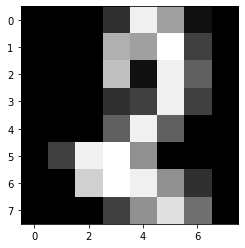

In [27]:
predictions = traininst.forward(images_tr)
labeldesired = interpretonehot(labels_tr)
labelpred = interpretonehot(predictions)
print(f"Error: {err(labeldesired, labelpred)}%")
ax = 51
print("This is (most likely) an:", labelpred[ax])
plt.imshow(images_tr[ax].reshape(int(np.sqrt(images_tr[ax].shape[0])), int(np.sqrt(images_tr[ax].shape[0]))), cmap='gray')
plt.show()